## Разные заметки

Сохранение для задания 19




База фоток пейзажей



база фоток

https://drive.google.com/drive/folders/16vBCau-fM-fvK46edtCzpzetqNzrPJK4

хорошее описание GAN сети

https://hardikbansal.github.io/CycleGANBlog/


Еще описание

https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling. This is in contrast to the original GAN paper, which used the maxout activation (Goodfellow et al., 2013)."

Вроде бы тут лучше видео по ганам, чем то, что на степике

https://www.youtube.com/watch?v=u2HDm7YSwoA

In [0]:
import pickle
import os
from PIL import Image
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from time import time
from IPython.display import clear_output

In [37]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 256x256 px
RESCALE_SIZE = 256
# запускаем на gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 1. Датасеты

In [38]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#apple2orange, horse2zebra, metal2choko, china2choko, money2choko
data_name = 'money2choko'

In [0]:
TRAIN_A_DIR = Path('/content/gdrive/My Drive/' + data_name + '/trainA') # horse
TRAIN_B_DIR = Path('/content/gdrive/My Drive/' + data_name + '/trainB')

TEST_A_DIR = Path('/content/gdrive/My Drive/' + data_name + '/testA')
TEST_B_DIR = Path('/content/gdrive/My Drive/' + data_name + '/testB')

In [0]:
train_A_files = list(TRAIN_A_DIR.rglob('*.jpg'))
test_A_files = list(TEST_A_DIR.rglob('*.jpg'))

train_B_files = list(TRAIN_B_DIR.rglob('*.jpg'))
test_B_files = list(TEST_B_DIR.rglob('*.jpg'))

In [42]:
len(train_A_files)

300

## 2. Даталоадеры

In [0]:
class HorsesDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, filesA, filesB, mode):
        super().__init__()
        if len(filesA) != len(filesB):
          raise Exception('Files A and B lenth doesn\'t match')

        # список файлов для загрузки
        self.filesA = sorted(filesA)
        self.filesB = sorted(filesB)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.filesA)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def fileA_name(self, file_number):
      return self.filesA[file_number]
    
    def fileB_name(self, file_number):
      return self.filesB[file_number]

    def find_1d_files(self):
      for i, _ in enumerate(tqdm_notebook(range(self.len_))):
        A = self._prepare_sample(self.load_sample(self.filesA[i]))
        B = self._prepare_sample(self.load_sample(self.filesB[i]))
        if A.shape[0] == 1:
          print('A', self.fileA_name(i))

        if B.shape[0] == 1:
          print('B', self.fileB_name(i))
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor()
            #,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        
            
        A = self.load_sample(self.filesA[index])
        B = self.load_sample(self.filesB[index])

        if self.mode == 'train':
            augs = transforms.RandomApply([
                #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop((RESCALE_SIZE, RESCALE_SIZE), scale=(0.5, 1)),
                transforms.RandomRotation(45)
            ], p=0.8)
        
            A = augs(A)
            B = augs(B)
                     
                
        A = self._prepare_sample(A)
        B = self._prepare_sample(B)
        #print('3', A)
        A = np.array(A / 127.5 - 1, dtype='float32')
        A = transform(A)
        B = np.array(B / 127.5 - 1, dtype='float32')
        B = transform(B)


        if self.mode == 'none':
            augs_torch = transforms.Compose([
                transforms.RandomErasing(p = 0.9,scale=(0.02, 0.10))
            ])
            x = augs_torch(x)
            
        return A, B

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
                
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = ((inp + 1) * 127.5).astype(int)
    #inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
minlenth_train = (min(len(train_A_files),len(train_B_files)))
minlenth_test = (min(len(test_A_files),len(test_B_files)))
test_A_files.sort()
test_B_files.sort()
test_dataset = HorsesDataset(test_A_files[:minlenth_test],test_B_files[:minlenth_test], mode='test')
train_dataset = HorsesDataset(train_A_files[:minlenth_train], train_B_files[:minlenth_train], mode='train')


/content/gdrive/My Drive/money2choko/trainB/depositphotos_1318490-stock-photo-euromo.jpg


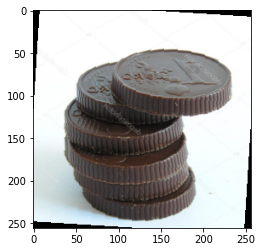

In [47]:
im_val1, im_val2 = train_dataset[200]
print(train_dataset.fileB_name(200))
imshow(im_val2.data.cpu())

## 3. Предобработка данных

In [0]:
#Поиск ч/б картинок (с одним каналом)
#train_dataset.find_1d_files()

## 4. Архитектура 

### 4.1 Генератор

In [0]:
class Generator_net(nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = nn.ReLU()
        self.tahn = nn.Tanh()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            #nn.Conv2d(3, 32, (7, 7), stride=1, padding = (3,3), padding_mode = 'reflect'),
            nn.Conv2d(3, 32, (7, 7), stride=1, padding = (3,3)),
            nn.ReLU(),
            nn.BatchNorm2d(32)           
        ) 
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), stride=2, padding = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(64)           
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, (3, 3), stride=2, padding = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(128)           
        )
        # 64, 64, 128

        # transform
        self.transform1 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform2 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform3 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform4 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform5 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform6 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform7 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform8 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )

        self.transform9 = nn.Sequential(
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=(1,1), padding_mode = 'reflect'),
            nn.BatchNorm2d(128)  
        )
        # 64, 64, 64

        # decoder (upsampling)
        self.de_conv0 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = (1,1), output_padding = (1,1)),# 16 -> 32
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.de_conv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride = 2, padding = (1,1), output_padding = (1,1)), # 32 -> 64
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.de_conv2 = nn.Sequential(
            nn.Conv2d(32, 3, (7, 7), padding = (3,3)),
            nn.BatchNorm2d(3)
        )


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)

        # transform
        b0_0 = self.transform1(e2)
        #b0_1 = self.relu(torch.cat([e2, b0_0], 1))
        b0_1 = self.relu(e2 + b0_0)

        b1_0 = self.transform2(b0_1)
        #b1_1 = self.relu(torch.cat([b0_1, b1_0], 1))
        b1_1 = self.relu(b0_1 + b1_0)

        b2_0 = self.transform3(b1_1)
        #b2_1 = self.relu(torch.cat([b1_1, b2_0], 1))
        b2_1 = self.relu(b1_1 + b2_0)

        b3_0 = self.transform4(b2_1)
        #b3_1 = self.relu(torch.cat([b2_1, b3_0], 1))
        b3_1 = self.relu(b2_1 + b3_0)

        b4_0 = self.transform5(b3_1)
        #b4_1 = self.relu(torch.cat([b3_1, b4_0], 1))
        b4_1 = self.relu(b3_1 + b4_0)

        b5_0 = self.transform6(b4_1)
        #b5_1 = self.relu(torch.cat([b4_1, b5_0], 1))
        b5_1 = self.relu(b4_1 + b5_0)

        b6_0 = self.transform7(b5_1)
        #b3_1 = self.relu(torch.cat([b2_1, b3_0], 1))
        b6_1 = self.relu(b5_1 + b6_0)

        b7_0 = self.transform8(b6_1)
        #b4_1 = self.relu(torch.cat([b3_1, b4_0], 1))
        b7_1 = self.relu(b6_1 + b7_0)

        b8_0 = self.transform9(b7_1)
        #b5_1 = self.relu(torch.cat([b4_1, b5_0], 1))
        b8_1 = self.relu(b7_1 + b8_0)

        # decoder
        d0 = self.de_conv0(b8_1)
        d1 = self.de_conv1(d0)
        d2 = self.de_conv2(d1)

        d3 = self.tahn(d2)  

        return d3



In [49]:
from torchsummary import summary # чтобы смотреть описание модели и ее параметров как в keras
model = Generator_net().to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
       BatchNorm2d-6         [-1, 64, 128, 128]             128
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
       BatchNorm2d-9          [-1, 128, 64, 64]             256
           Conv2d-10          [-1, 128, 64, 64]         147,584
             ReLU-11          [-1, 128, 64, 64]               0
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

### 4.2 Дискриминатор

In [0]:
import random
def RandomCrop(x, size, side_size):
    stop =  x.shape[2] - side_size
    start = random.randint(side_size, stop - size)
  
    x = x[:,:,start:start+size,start:start+size]
    return x

In [0]:
class Discriminator_net(nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = nn.ReLU()
        self.tahn = nn.Tanh()
        self.sig = nn.Sigmoid()

        self.conv0 = nn.Sequential(
            nn.Conv2d(3, 32, (4, 4), stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)           
        ) 
        self.conv1 = nn.Sequential(
            nn.Conv2d(32, 64, (4, 4), stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, (4, 4), stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)           
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, (4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(256)           
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 1, (4, 4))          
        )

    def forward(self, x):
        # encoder
        x = RandomCrop(x, 70, 55)
        e0 = self.conv0(x)
        e1 = self.conv1(e0)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        
        #d3 = self.tahn(e4)  

        return e4

In [52]:
model = Discriminator_net().to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]           1,568
              ReLU-2           [-1, 32, 34, 34]               0
       BatchNorm2d-3           [-1, 32, 34, 34]              64
            Conv2d-4           [-1, 64, 16, 16]          32,832
              ReLU-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7            [-1, 128, 7, 7]         131,200
              ReLU-8            [-1, 128, 7, 7]               0
       BatchNorm2d-9            [-1, 128, 7, 7]             256
           Conv2d-10            [-1, 256, 4, 4]         524,544
             ReLU-11            [-1, 256, 4, 4]               0
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13              [-1, 1, 1, 1]           4,097
Total params: 695,201
Trainable params:

## 5. Loss function

## 5. Настройка модели, гиперпараметры

In [0]:
gen_A = Generator_net().to(device)
gen_B = Generator_net().to(device)

dec_A = Discriminator_net().to(device)
dec_B = Discriminator_net().to(device)

In [54]:
gen_A

Generator_net(
  (relu): ReLU()
  (tahn): Tanh()
  (enc_conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (transform1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding

## 6. Обучение

In [0]:
def train(gen_A, gen_B, dec_A, dec_B, epochs, data_tr, data_val):
    
    train_loader = DataLoader(data_tr, batch_size=1, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=1, shuffle=False)
    val_iterator = iter(val_loader)

    history = []
    
    opt_G_A = optim.Adam(gen_A.parameters(),  lr = 0.0003)
    opt_G_B = optim.Adam(gen_B.parameters(),  lr = 0.0003)


    opt_D_A = optim.Adam(dec_A.parameters(), lr = 0.00001)
    opt_D_B = optim.Adam(dec_B.parameters(), lr = 0.00001)


    MAE_loss = nn.L1Loss().to(device)
    MSE_loss = nn.MSELoss().to(device)
    BCE_Loss = nn.BCELoss().to(device)
    BCE_Logits_Loss = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_A_dec_loss = 0
        avg_B_dec_loss = 0
        avg_A_gen_loss = 0
        avg_B_gen_loss = 0
        avg_gen_identity_loss = 0
        avg_gen_cycle_loss = 0
        avg_gen_GAN_loss = 0

        gen_A.train()
        gen_B.train()
        dec_A.train()
        dec_B.train()  # train mode
        
        k_identity = int(epoch / 50)
        k_GAN = int(epoch / 50)
        for batch_idx, (A_batch, B_batch) in enumerate(tqdm_notebook(train_loader)):
        #for i, batch in tqdm(train_loader):

            #pic_number += 1
            # data to device
            A_real = A_batch.to(device)
            B_real = B_batch.to(device)

            batch_size = A_batch.size(0)
            ones = torch.full((batch_size, 1, 1, 1), 1, device=device, dtype=torch.float32)
            zeros = torch.full((batch_size, 1, 1, 1), 0, device=device, dtype=torch.float32)
            ####################################################
            #               Generators training                #
            ####################################################

            opt_G_A.zero_grad()
            opt_G_B.zero_grad()

            # forward
            # identity losses
            A_fromA = gen_A(A_real)
            B_fromB = gen_B(B_real)
            id_A_loss = MAE_loss(A_fromA, A_real)
            id_B_loss = MAE_loss(B_fromB, B_real)

            # GAN losses
            B_gen = gen_B(A_real)
            B_gen_check = dec_B(B_gen)

            A_gen = gen_A(B_real)
            A_gen_check = dec_A(A_gen)

            #GAN_A_loss = MSE_loss(A_gen_check, ones)
            #GAN_B_loss = MSE_loss(B_gen_check, ones)
            
            GAN_A_loss = BCE_Logits_Loss(A_gen_check, ones)
            GAN_B_loss = BCE_Logits_Loss(B_gen_check, ones)

            # cycle losses
            A_fromB_gen = gen_A(B_gen)
            B_fromA_gen = gen_B(A_gen)

            cycle_loss_A = MAE_loss(A_fromB_gen, A_real)
            cycle_loss_B = MAE_loss(B_fromA_gen, B_real)

            # Combined loss and calculate gradients
            total_G_A_loss = id_A_loss * 5  + GAN_A_loss + cycle_loss_B * 5 + cycle_loss_A * 5 
            total_G_B_loss = id_B_loss * 5  + GAN_B_loss + cycle_loss_B * 5 + cycle_loss_A * 5
            #total_G_loss = id_A_loss*5  + id_B_loss*5 + GAN_A_loss + GAN_B_loss + cycle_loss_A*5  + cycle_loss_B*5 

            total_G_A_loss.backward(retain_graph=True)
            total_G_B_loss.backward()

            opt_G_A.step()
            opt_G_B.step()

            ####################################################
            #             Discriminator A training             #
            ####################################################
            opt_D_A.zero_grad()

            # correct img
            A_correct_check = dec_A(A_real)
            #A_correct_loss = MSE_loss(A_correct_check, ones)
            A_correct_loss = BCE_Logits_Loss(A_correct_check, ones)
                        
            # generated img
            A_gen_check = dec_A(A_gen.detach())
            #A_gen_loss =  MSE_loss(A_gen_check, zeros)
            A_gen_loss =  BCE_Logits_Loss(A_gen_check, zeros)

            total_dec_A_loss = (A_correct_loss   + A_gen_loss) / 2

            total_dec_A_loss.backward()

            opt_D_A.step()

            ####################################################
            #             Discriminator B training             #
            ####################################################
            opt_D_B.zero_grad()

            # correct img
            B_correct_check = dec_B(B_real)
            #B_correct_loss = MSE_loss(B_correct_check, ones)
            B_correct_loss = BCE_Logits_Loss(B_correct_check, ones)

            # generated img
            B_gen_check = dec_B(B_gen.detach())
            #B_gen_loss =  MSE_loss(B_gen_check, zeros)
            B_gen_loss =  BCE_Logits_Loss(B_gen_check, zeros)
            # new!
            total_dec_B_loss = (B_correct_loss  + B_gen_loss) / 2

            total_dec_B_loss.backward()

            opt_D_B.step()

            ####################################################
            #                   Calculations                   #
            ####################################################

            if batch_idx % 500 == 1:
              print('A_correct_check:', A_correct_check, 'A_gen_check',A_gen_check, 'B_correct_check:', B_correct_check, 'B_gen_check',B_gen_check)

            # calculate loss to show the user
            avg_loss += (total_G_A_loss.item() + total_G_B_loss.item() + total_dec_A_loss.item() + total_dec_B_loss.item())/ len(data_tr)
            avg_A_dec_loss += total_dec_A_loss.item() / len(data_tr)
            avg_B_dec_loss += total_dec_B_loss.item() / len(data_tr)
            avg_A_gen_loss += total_G_A_loss.item() / len(data_tr)
            avg_B_gen_loss += total_G_B_loss.item() / len(data_tr)

            avg_gen_identity_loss += (id_A_loss.item() + id_B_loss.item())/ len(data_tr)
            avg_gen_cycle_loss += (cycle_loss_A.item() + cycle_loss_B.item())/ len(data_tr)
            avg_gen_GAN_loss += (GAN_A_loss.item() + GAN_B_loss.item())/ len(data_tr)

        
        toc = time()
        
        print('loss: %f' % avg_loss)
        
        history.append((avg_loss, avg_A_dec_loss, avg_B_dec_loss, avg_A_gen_loss, avg_B_gen_loss, avg_gen_identity_loss, avg_gen_cycle_loss, avg_gen_GAN_loss))


        # Visualize tools
        gen_A.eval()
        gen_B.eval()
        dec_A.eval()
        dec_B.eval() 

        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True, sharex=True)
        examples = random.choices(data_val, k=2)

        for i in range(2):

          with torch.no_grad():
            val_A, val_B = examples[i]

            val_A = val_A.unsqueeze(0).to(device)
            val_B = val_B.unsqueeze(0).to(device)

            val_B_gen = gen_B(val_A)
            val_A_gen = gen_A(val_B)
          
            val_A_gen_from_B = gen_A(val_B_gen)
            val_B_gen_from_A = gen_B(val_A_gen)


          imshow(val_A[0].detach().cpu(), title='Real A', plt_ax=ax[0,0 + i*2])
          imshow(val_B_gen[0].detach().cpu(), title='Gen B', plt_ax=ax[1,0 + i*2])
          imshow(val_A_gen_from_B[0].detach().cpu(), title='Gen A from B', plt_ax=ax[2,0 + i*2])

          imshow(val_B[0].detach().cpu(), title='Real B', plt_ax=ax[0,1 + i*2])
          imshow(val_A_gen[0].detach().cpu(), title='Gen A', plt_ax=ax[1,1 + i*2])
          imshow(val_B_gen_from_A[0].detach().cpu(), title='Gen B from A', plt_ax=ax[2,1 + i*2])

        plt.suptitle('%d / %d - avg loss: %f, dec A loss %f, dec B loss: %f, gen loss A: %f , gen loss B: %f (id: %f, cycle: %f, GAN: %f)'\
                     % (epoch+1, epochs, avg_loss, avg_A_dec_loss, avg_B_dec_loss, avg_A_gen_loss, avg_B_gen_loss, avg_gen_identity_loss, avg_gen_cycle_loss, avg_gen_GAN_loss))
        plt.show()

    return history

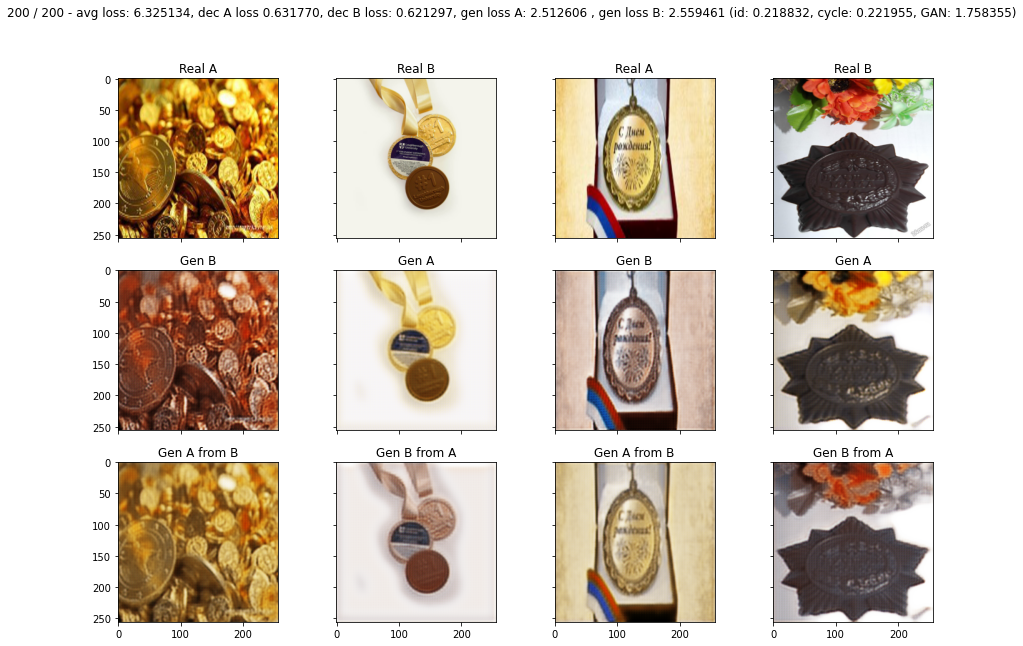

In [61]:
 result = train(gen_A, gen_B, dec_A, dec_B, 200, train_dataset, test_dataset)


[(12.638306161831052, 0.6896046901426988, 0.6883243197780793, 5.745572160318943, 5.514804991591336, 0.6222222113489712, 0.6522716396429065, 1.6265496854299681), (11.931441536316512, 0.6731074696599837, 0.7093658862903368, 5.381890810452974, 5.167077369913213, 0.5808442141798428, 0.6069026525602691, 1.5757205597433355), (11.605752494721912, 0.6887857084688935, 0.6992311751762761, 5.234414107823447, 4.983321503253289, 0.5557453668984687, 0.5836152468985542, 1.6028562622225804), (11.297389786378998, 0.6945401162008772, 0.6838098330840611, 5.058906744953784, 4.86013309214028, 0.5428904307676001, 0.562075453483341, 1.5838331227816873), (11.497930561170541, 0.7167639739836341, 0.719779840879217, 5.14562852964752, 4.915758216660159, 0.5483039589629927, 0.5689192624345267, 1.6306743045714374), (10.927678420491842, 0.7002914178132211, 0.6859028213797606, 4.863344143066921, 4.678140038231943, 0.5174646444842963, 0.5386392081461622, 1.5677688433274783), (11.015931464656937, 0.6903164019951453, 0.

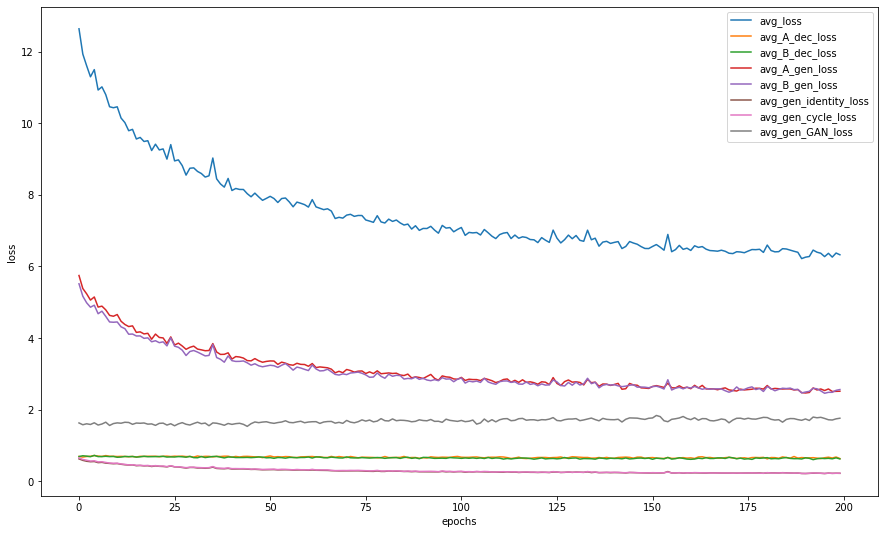

In [62]:
print(result)

avg_loss, avg_A_dec_loss, avg_B_dec_loss, avg_A_gen_loss, avg_B_gen_loss, avg_gen_identity_loss, avg_gen_cycle_loss, avg_gen_GAN_loss = zip(*result)

plt.figure(figsize=(15, 9))
plt.plot(avg_loss, label="avg_loss")
plt.plot(avg_A_dec_loss, label="avg_A_dec_loss")
plt.plot(avg_B_dec_loss, label="avg_B_dec_loss")
plt.plot(avg_A_gen_loss, label="avg_A_gen_loss")
plt.plot(avg_B_gen_loss, label="avg_B_gen_loss")
plt.plot(avg_gen_identity_loss, label="avg_gen_identity_loss")
plt.plot(avg_gen_cycle_loss, label="avg_gen_cycle_loss")
plt.plot(avg_gen_GAN_loss, label="avg_gen_GAN_loss")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## 7. Сохранение / загрузка весов

In [0]:
save_path = 'gdrive/My Drive/money2choko/BCE-'

Сохраним веса, если получилось хорошо

In [0]:
torch.save(gen_A.state_dict(), save_path + 'gen_A.pt')
torch.save(gen_B.state_dict(), save_path + 'gen_B.pt')
torch.save(dec_A.state_dict(), save_path + 'dec_A.pt')
torch.save(dec_B.state_dict(), save_path + 'dec_B.pt')

Загрузим веса, если хотим работать с обученной моделью

In [0]:
#gen_A.load_state_dict(torch.load(save_path + 'gen_A.pt'))
#gen_B.load_state_dict(torch.load(save_path + 'gen_B.pt'))
#dec_A.load_state_dict(torch.load(save_path + 'dec_A.pt'))
#dec_B.load_state_dict(torch.load(save_path + 'dec_B.pt'))

## 8. Валидация

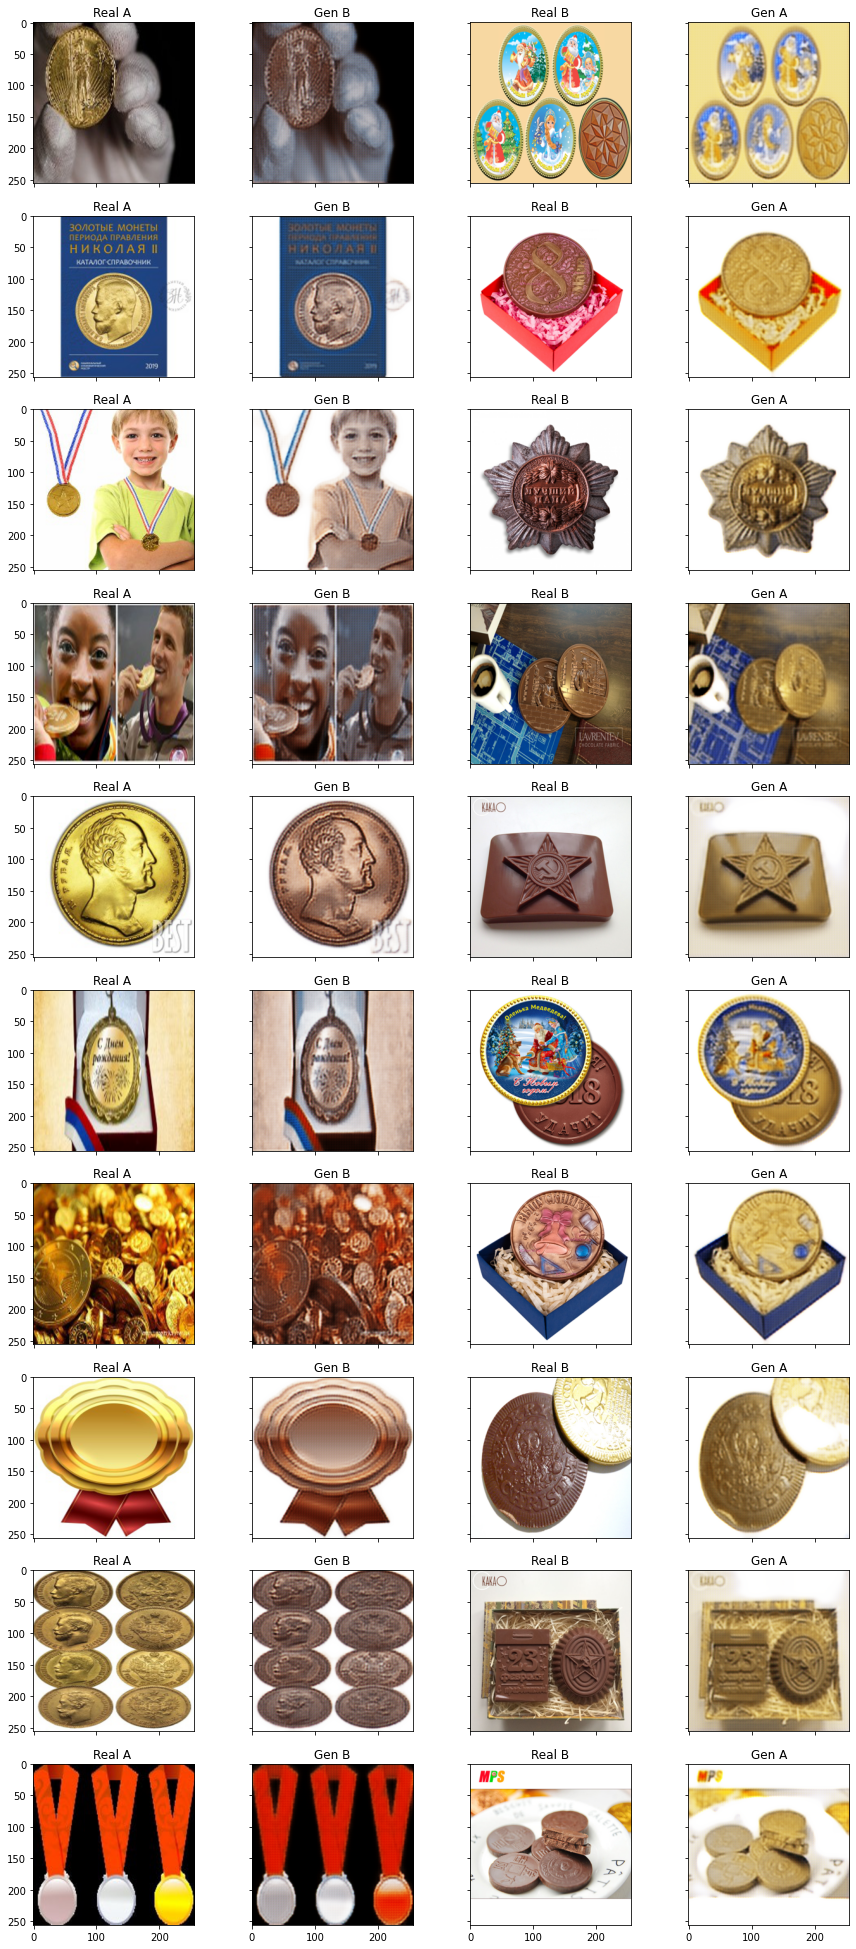

In [76]:
fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(15, 35), sharey=True, sharex=True)

gen_A.eval()
gen_B.eval()
dec_A.eval()
dec_B.eval() 

start_from = 0
for i in range(10):

  with torch.no_grad():
    val_A, val_B = test_dataset[start_from + i]

    val_A = val_A.unsqueeze(0).to(device)
    val_B = val_B.unsqueeze(0).to(device)

    val_B_gen = gen_B(val_A)
    val_A_gen = gen_A(val_B)

  imshow(val_A[0].detach().cpu(), title='Real A ', plt_ax=ax[i,0])
  imshow(val_B_gen[0].detach().cpu(), title='Gen B', plt_ax=ax[i,1])
  imshow(val_B[0].detach().cpu(), title='Real B', plt_ax=ax[i,2])
  imshow(val_A_gen[0].detach().cpu(), title='Gen A', plt_ax=ax[i,3])

plt.show()

## Резюме

Было очень интересно и полезно воспроизвести код всей модели по чужому словесному описанию. Найденные грабли целиком оправдывают потраченное время. 
Я выбрала датасет шоколданые медали - в настоящие, собирала его по крупицам, объем датасета небольшой, но за счет аугментации и большого числа эпох, модель в итоге сходится.
В самой модели я использовала ВСЕ лосс вместо квадратичного отклонения, с ним у меня результат получился стабильно лучше.

В целом результат работы мне кажется хорошим.
Однако, если до этого места кто-то дочитал, и есть возможность получить совет, рекомендацию, или чем черт не шутит, код-ревью, то очень хотелось бы понять, где я налажала. Модель хоть и сходится, но кажется, это из-за довольно простого датасета, т.к. зебр в лошадей и обратно мне превратить не удалось.

Вообще большое спасибо за то, что двигаете нас к чтению исходных документов-исследований и к воспроизведению с нуля различных свежих разработок. Это просто здорово!